# 0. 紀錄

- 20240425_1541 : LeNet_Adam，使用Adam optimizer，epoch = 50，lr=0.0001
- 20240425_1551 : LeNet_SGD，使用SGD optimizer，epoch = 200，lr = 0.0001，momentum = 0.9
- 20240425_1600 : LeNet_RMSprop，使用RMSprop optimizer，epoch = 50，lr = 0.0001


|           | accruacy |avg precision(marco/weighted)|avg recall(marco/weighted)|f1-score(marco/weighted)|
|:---------:|:--------:|:---------------------------:|:------------------------:|:----------------------:|
|Adam       |   0.84   |          0.80/0.85          |        0.77/0.84         |        0.78/0.84       |
|SGD        |   0.85   |          0.80/0.85          |        0.79/0.85         |        0.79/0.85       |
|**RMSprop**| **0.86** |        **0.83/0.86**        |      **0.80/0.86**       |      **0.81/0.86**     |

-> 根據結果，選用RMSprop作為optimizer

------------
- 20240425_1705 : LeNet_RMSprop_DA，使用RMSprop optimizer，epoch = 50，lr = 0.0001，加上資料增強(rotation, zoom)

|           | accruacy |avg precision(marco/weighted)|avg recall(marco/weighted)|f1-score(marco/weighted)|
|:---------:|:--------:|:---------------------------:|:------------------------:|:----------------------:|
|**RMSprop**| **0.89** |        **0.86/0.89**        |      **0.84/0.89**       |      **0.84/0.89**     |

-> 嘗試使用learning rate warmup 和 decay，並且添加dropout

------------
- 20240425_1733 : LeNet_RMSprop_DO_LS，除了資料增強，使用learning rate warmup(epoch = 5) 和 decay(epoch = 30, rate = -0.1)，並且添加dropout在fc2之後(rate = 0.5)

|           | accruacy |avg precision(marco/weighted)|avg recall(marco/weighted)|f1-score(marco/weighted)|
|:---------:|:--------:|:---------------------------:|:------------------------:|:----------------------:|
|**RMSprop**| **0.87** |        **0.85/0.87**        |      **0.80/0.87**       |      **0.81/0.86**     |

-> 結果沒有提升，反而下降了一點，且一開始的提升速度較慢，加入momentum，加快收斂速度，並且延後decay時間(epoch = 40)

-----------
- 20240425_2000 : LeNet_RMSprop_04，設定momentum=0.9，decay_epoch=40

|           | accruacy |avg precision(marco/weighted)|avg recall(marco/weighted)|f1-score(marco/weighted)|
|:---------:|:--------:|:---------------------------:|:------------------------:|:----------------------:|
|**RMSprop**| **0.93** |        **0.91/0.93**        |      **0.90/0.93**       |      **0.90/0.93**     |

-> 根據網路上查到的資料(https://towardsdatascience.com/classification-of-traffic-signs-with-lenet-5-cnn-cb861289bd62)，他們只使用了灰階圖片作為訓練。因此嘗試把資料輸入只有灰階圖片，看看效果如何。

----------
- 20240426_1522 : LeNet_RMSprop_05，只輸入灰階圖片

|           | accruacy |avg precision(marco/weighted)|avg recall(marco/weighted)|f1-score(marco/weighted)|
|:---------:|:--------:|:---------------------------:|:------------------------:|:----------------------:|
|**RMSprop**| **0.94** |        **0.92/0.95**        |      **0.91/0.94**       |      **0.91/0.94**     |

-> 根據confuse matrix的觀察，speed limit的標誌還是有一小部分容易判斷錯誤。嘗試在fc1和fc2之間在加一層dropout，epoch=100。

----------
- 20240426_1600 : LeNet_RMSprop_06，只輸入灰階圖片

|           | accruacy |avg precision(marco/weighted)|avg recall(marco/weighted)|f1-score(marco/weighted)|
|:---------:|:--------:|:---------------------------:|:------------------------:|:----------------------:|
|**RMSprop**| **0.92** |        **0.88/0.92**        |      **0.84/0.92**       |      **0.85/0.92**     |

-> 結果反而下降，回到上一步。嘗試正規化。


# 1. 資料集瀏覽

---
數據集是以 pickle 格式存儲的字典，包含四個鍵/值對：

- `'features'` 是一個4D數組，包含交通標誌圖像的原始像素數據，形狀為 (樣本數, 寬度, 高度, 通道數)。

- `'labels'` 是一維數組，包含交通標誌的類別標籤/ID。文件 `signnames.csv` 包含 ID 到名稱的映射。

- `'sizes'` 是一個列表，包含元組 (寬度, 高度)，表示圖像的原始寬度和高度。

- `'coords'` 是一個列表，包含元組 (x1, y1, x2, y2)，表示圖像中標誌周圍邊界框的坐標。這些坐標假定原始圖像的尺寸。pickle數據包含了這些圖像的調整版本（32x32）

## 從pickle檔案讀取資料集

In [1]:
import pickle

# 定義訓練、驗證和測試數據的文件路徑
training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

# 使用pickle加載數據集
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# 從數據中獲取特徵和標籤
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


## 檢查資料數量

In [2]:
import numpy as np
import random
import pandas as pd

# 計算訓練數據集的數量
n_train = len(X_train)

# 計算驗證數據集的數量
n_valid = len(X_valid)

# 計算測試數據集的數量
n_test = len(X_test)

# 計算交通標誌圖像的形狀
image_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3]]

# 計算數據集中獨特的類別/標籤數量
def getLabelsCount(labels):
    # 建立一個具有相同長度的初始計數列表，其中每個標籤的初始計數都是 0
    d = dict(zip(labels, [0] * len(labels)))
    for x in labels:
        d[x] += 1
    return d

# 獲取訓練集標籤的計數
signsDicts = getLabelsCount(y_train)
# 計算類別/標籤的數量
n_classes = len(signsDicts)

# 打印摘要信息
print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 43


## 輸出每一類的一些樣本

In [3]:
# 載入必要的庫
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 在Notebook中顯示圖片
%matplotlib inline

# 定義函數來獲取交通標誌的名稱
def getSignNames():
    return pd.read_csv('./signnames.csv').values

# 定義函數來繪製交通標誌的圖片
def plotImages(X, y, examples_per_sign=15, squeeze=False, cmap=None):
    # 獲取每個交通標誌的樣本數量
    samples_per_sign = np.bincount(y)
    # 遍歷每個交通標誌
    for sign in getSignNames():
        print("{0}. {1} - Samples: {2}".format(sign[0], sign[1], samples_per_sign[sign[0]]))
        # 獲取特定交通標誌的樣本索引
        sample_indices = np.where(y==sign[0])[0]
        # 隨機選取指定數量的樣本
        random_samples = random.sample(list(sample_indices), examples_per_sign)
        # 繪製圖片
        fig = plt.figure(figsize = (examples_per_sign, 1))
        fig.subplots_adjust(hspace = 0, wspace = 0)
        for i in range(examples_per_sign):
            image = X[random_samples[i]]
            axis = fig.add_subplot(1,examples_per_sign, i+1, xticks=[], yticks=[])
            if squeeze: image = image.squeeze()
            if cmap == None: axis.imshow(image)
            else: axis.imshow(image.squeeze(), cmap=cmap)
        plt.show()
        print("----------------------------------------------------------------------------\n")

# 使用定義的函數來繪製訓練數據中的圖片
# plotImages(X_train, y_train)



Bad key "text.kerning_factor" on line 4 in
d:\anaconda3\envs\tf2.5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## 每一類別的數量

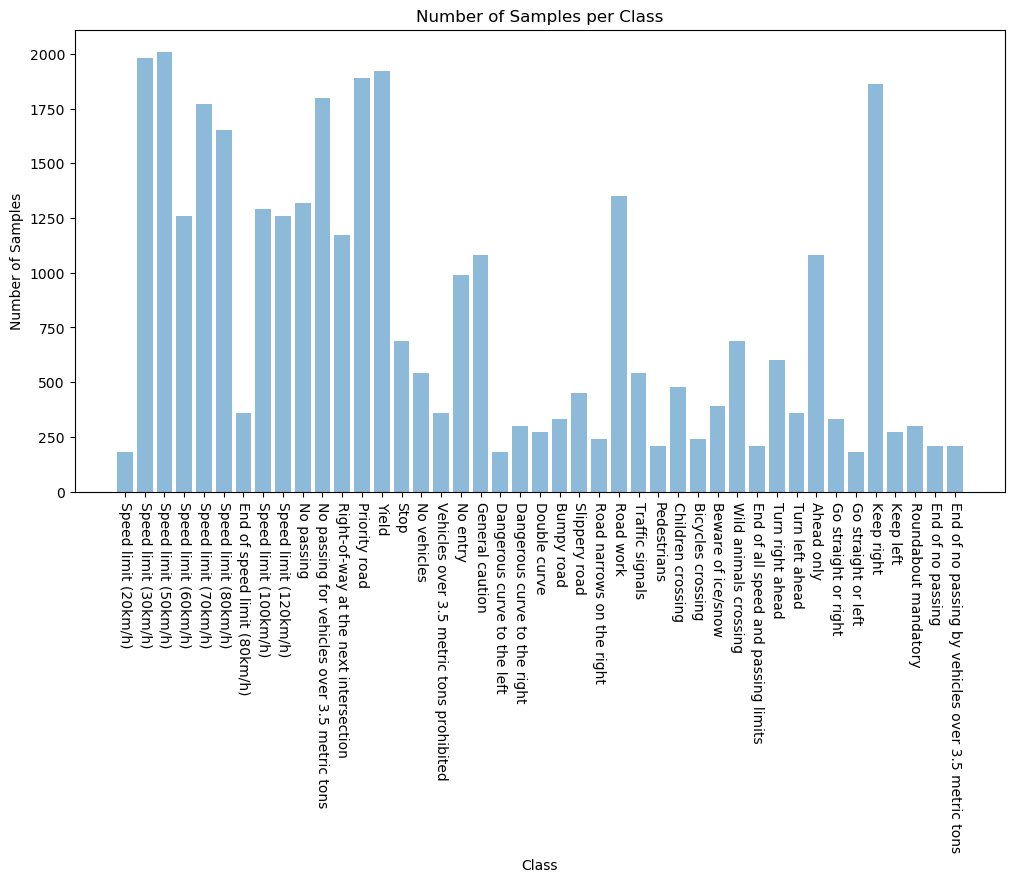

In [4]:
# 設置圖表大小
plt.figure(figsize=(12, 6))  # 調整圖表大小以容納長的類別名稱

# 獲取每個類別的樣本數量
class_counts = np.bincount(y_train)

# 獲取類別名稱
class_names = [name[1] for name in getSignNames()]

# 繪製直方圖
plt.bar(range(n_classes), class_counts, align='center', alpha=0.5)

# 添加標題和標籤
plt.title('Number of Samples per Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

# 設置 x 軸刻度標籤
plt.xticks(range(n_classes), class_names, rotation=270)  # 將類別名稱設置為 x 軸刻度標籤，並旋轉 90 度以避免重疊

# 顯示圖表
plt.show()



## 隨機顯示一張樣本

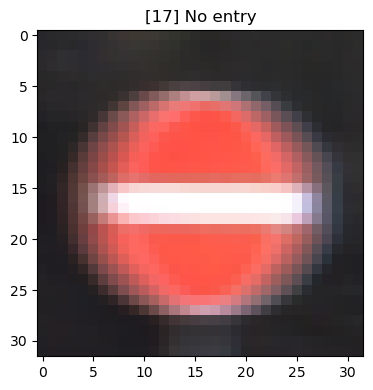

In [5]:
# 從訓練數據中隨機選擇一個索引
index = random.randint(0, len(X_train))
# 獲取訓練數據集的大小
X_train_cnt = len(X_train)
# 提取圖像
image = X_train[index].squeeze()
# 取得label名稱列表
label_list  = getSignNames()

# 顯示圖像
plt.figure(figsize=(4,4))
# 使用 f 字串來包含標籤編號和名稱
plt.title(f"[{label_list[y_train[index]][0]}] {label_list[y_train[index]][1]}")  
plt.imshow(image)
plt.tight_layout()
plt.show()



# 2. 設計和測試模型架構

## 檢查tensorflow版本和可用gpu

In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# 檢查tensorflow版本
print("tensorflow version : ", tf.__version__)
# 檢查可用gpu
print("GPU available : ", tf.test.is_gpu_available())
# Device list
print(device_lib.list_local_devices())

tensorflow version :  2.5.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available :  True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4347135396850547273
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2236822324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17582614803152978910
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Random Seed set

In [7]:
random_seed = 42
# 設定 numpy 的隨機種子
np.random.seed(random_seed)

# 設定 tensorflow 的隨機種子
tf.random.set_seed(random_seed)

## 資料前處理

In [14]:
def data_preprocess(images):
    # RGB圖像轉換為灰度圖像並進行預處理
    gray =np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    # 對灰度圖像進行正規化
    normalized_gray_images = [(gray_img - np.min(gray_img)) / (np.max(gray_img) - np.min(gray_img)) for gray_img in gray]
    normalized_gray_images = np.expand_dims(normalized_gray_images,axis=3)
    # 原始RGB圖像數據和灰度圖像數據合併
    # images_all = np.append(images,gray,axis=3)
    return normalized_gray_images

In [34]:

X_train_all = data_preprocess(X_train)

X_test_all = data_preprocess(X_test)

X_valid_all = data_preprocess(X_valid)

print(f"X_train_all shape : {X_train_all.shape}")
print(f"X_test_all shape : {X_test_all.shape}")
print(f"X_valid_all shape : {X_valid_all.shape}")


X_train_all shape : (34799, 32, 32, 1)
X_test_all shape : (12630, 32, 32, 1)
X_valid_all shape : (4410, 32, 32, 1)


In [43]:
from sklearn.utils import shuffle
# 打亂順序
X_train_shuffled, y_train_shuffled = shuffle(X_train_all, y_train, random_state=random_seed)

## Data Augmentation

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 創建 ImageDataGenerator 對象，並設置資料增強的參數
datagen = ImageDataGenerator(
    rotation_range=10,  # 隨機旋轉範圍（0~10度之間）
    zoom_range=0.1,  # 隨機縮放範圍（0.9~1.1倍之間）
)

# 對訓練集圖像數據進行資料增強
datagen.fit(X_train_shuffled)

## 將 Label 轉換成 One-Hot Encode


In [46]:
from tensorflow.keras.utils import to_categorical

# 將標籤轉換為 one-hot 編碼
y_train_onehot = to_categorical(y_train_shuffled, num_classes=43) 
y_valid_onehot = to_categorical(y_valid, num_classes=43)
y_test_onehot = to_categorical(y_test, num_classes=43)

print("y shape :")
print(f"y_train = {y_train_onehot.shape}")
print(f"y_valid = {y_valid_onehot.shape}")
print(f"y_test = {y_test_onehot.shape}")

y shape :
y_train = (34799, 43)
y_valid = (4410, 43)
y_test = (12630, 43)


## LeNet 架構

In [47]:
from tensorflow.keras import layers, models

# 定義LeNet模型
def LeNet(input_shape, use_dropout=False, dropout_rate=0.5):
    model = models.Sequential()
    
    # 第一個卷積層
    # 使用6個5x5的卷積核，激活函數為ReLU，輸入形狀為input_shape
    model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
    
    # 第一個池化層
    # 使用2x2的池化窗口進行最大池化，步幅為2
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # 第二個卷積層
    # 使用16個5x5的卷積核，激活函數為ReLU
    model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
    
    # 第二個池化層
    # 使用2x2的池化窗口進行最大池化，步幅為2
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # 將多維數組展平為一維
    model.add(layers.Flatten())
    
    # 第一個全連接層
    # 使用120個神經元，激活函數為ReLU
    model.add(layers.Dense(120, activation='relu'))

    # # Dropout
    # if use_dropout:
    #     model.add(layers.Dropout(dropout_rate,))

    # 第二個全連接層
    # 使用84個神經元，激活函數為ReLU
    model.add(layers.Dense(84, activation='relu'))

    # Dropout
    if use_dropout:
        model.add(layers.Dropout(dropout_rate,))
    
    # 輸出層
    # 使用43個神經元，激活函數為softmax，用於多類別分類
    model.add(layers.Dense(43, activation='softmax'))
    
    return model



In [48]:
from tensorflow.keras import backend as K

# 定義輸入圖片大小
# input_shape = (32, 32, 4)
input_shape = (32, 32, 1)

# 清除之前的模型和 TensorFlow 圖形
K.clear_session()

# 創建LeNet模型
model = LeNet(input_shape, use_dropout=True)

# 印出模型摘要
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

# 3. 開始訓練 

## 訓練參數設定

In [49]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

model_path = "Model/LeNet_RMSprop_07.h5"

initial_lr = 0.0001

# 指定優化器
optimizer = RMSprop(learning_rate=initial_lr, momentum=0.9)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


## Callback 設定

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

warmup_epoch = 5
decay_epoch = 40
decay_rate = -0.1

# 收集學習率值
lr_values = []

# learning rate scheduler
def lr_scheduler(epoch, lr):
    # 調整learning rate
    # warmup
    if epoch < warmup_epoch:
        lr = initial_lr*(epoch+1)/5

    # decay
    if epoch < decay_epoch:
        lr = lr
    else:
        lr = lr*np.exp(decay_rate)

    lr_values.append(lr)  # 收集學習率值
    return lr

# Create learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_scheduler)

# 定義 ModelCheckpoint Callback，用於保存具有最佳驗證集表現的模型
checkpoint_callback = ModelCheckpoint(model_path, save_best_only=True)
# 定義 EarlyStopping Callback，用於在驗證集損失不再改善時停止訓練
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)



## 訓練Model

In [51]:
# # 模型訓練
# history = model.fit(X_train_all, y_train_onehot, epochs=50, batch_size=256, validation_data=(X_valid_all, y_valid_onehot), 
#                     callbacks=[checkpoint_callback])

# 使用生成器訓練模型
history = model.fit(datagen.flow(X_train_shuffled, y_train_onehot, batch_size=256),
                    epochs=100,
                    validation_data=(X_valid_all, y_valid_onehot),
                    callbacks=[lr_scheduler, checkpoint_callback])


Epoch 1/100
136/136 [==============================] - 10s 60ms/step - loss: 3.5945 - accuracy: 0.0604 - val_loss: 3.4262 - val_accuracy: 0.1438
Epoch 2/100
136/136 [==============================] - 8s 61ms/step - loss: 3.1338 - accuracy: 0.1889 - val_loss: 2.6268 - val_accuracy: 0.3444
Epoch 3/100
136/136 [==============================] - 9s 68ms/step - loss: 2.3670 - accuracy: 0.3572 - val_loss: 1.7177 - val_accuracy: 0.5619
Epoch 4/100
136/136 [==============================] - 9s 68ms/step - loss: 1.6966 - accuracy: 0.5172 - val_loss: 1.1537 - val_accuracy: 0.6816
Epoch 5/100
136/136 [==============================] - 9s 66ms/step - loss: 1.2281 - accuracy: 0.6387 - val_loss: 0.7987 - val_accuracy: 0.7723
Epoch 6/100
136/136 [==============================] - 10s 72ms/step - loss: 0.9162 - accuracy: 0.7270 - val_loss: 0.6006 - val_accuracy: 0.8306
Epoch 7/100
136/136 [==============================] - 8s 55ms/step - loss: 0.7297 - accuracy: 0.7787 - val_loss: 0.5130 - val_accurac

In [52]:
from keras.models import  save_model
save_model(model,model_path)

## 繪製 Loss & Accuracy Curve

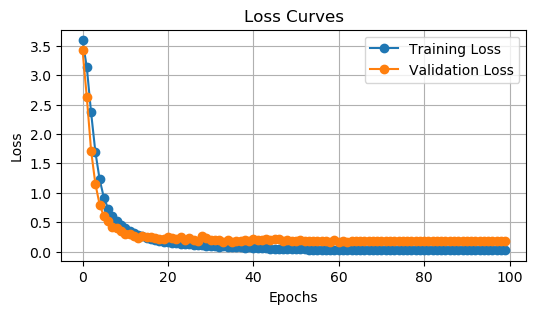

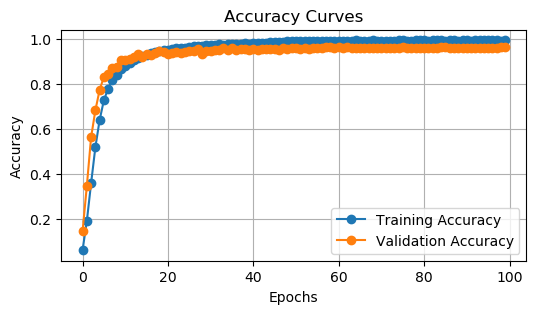

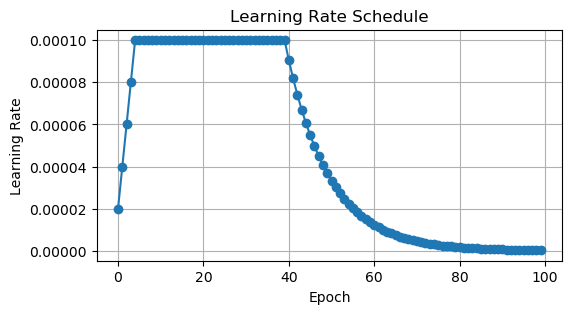

In [53]:
# 取得訓練過程中的損失和準確度
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 繪製損失曲線
plt.figure(figsize=(6, 3))
plt.plot(train_loss, label='Training Loss', marker="o")
plt.plot(val_loss, label='Validation Loss', marker="o")
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # 添加格線
plt.show()

# 繪製準確度曲線
plt.figure(figsize=(6, 3))
plt.plot(train_acc, label='Training Accuracy', marker="o")
plt.plot(val_acc, label='Validation Accuracy', marker="o")
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  # 添加格線
plt.show()

# 繪製學習率曲線
plt.figure(figsize=(6, 3))
plt.plot(lr_values, marker="o")
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)  # 添加格線
plt.show()

# 4. Evaluation

In [54]:
from keras.models import load_model
# 加載最佳模型
best_model = load_model(model_path)
# 測試模型
test_loss, test_accuracy = best_model.evaluate(X_test_all, y_test_onehot, batch_size=256)

50/50 [==============================] - 1s 6ms/step - loss: 0.4800 - accuracy: 0.9394


## 預測

In [55]:
from sklearn.metrics import classification_report


# 對測試集進行預測
y_pred = best_model.predict(X_test_all, batch_size=256)

# 將預測結果轉換為類別編號
y_pred = np.argmax(y_pred, axis=1)

# 生成分類報告
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

           0       0.95      0.92      0.93        60
           1       0.92      0.98      0.95       720
           2       0.94      0.95      0.95       750
           3       0.91      0.94      0.93       450
           4       0.95      0.95      0.95       660
           5       0.91      0.91      0.91       630
           6       0.98      0.83      0.90       150
           7       0.98      0.86      0.92       450
           8       0.89      0.95      0.92       450
           9       0.96      1.00      0.98       480
          10       0.98      0.99      0.98       660
          11       0.92      0.90      0.91       420
          12       0.98      0.98      0.98       690
          13       0.99      0.99      0.99       720
          14       0.99      0.94      0.96       270
          15       0.98      0.98      0.98       210
          16       0.97      0.99      0.98       150
          17       1.00    

## 繪製Confuse Metrix

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)


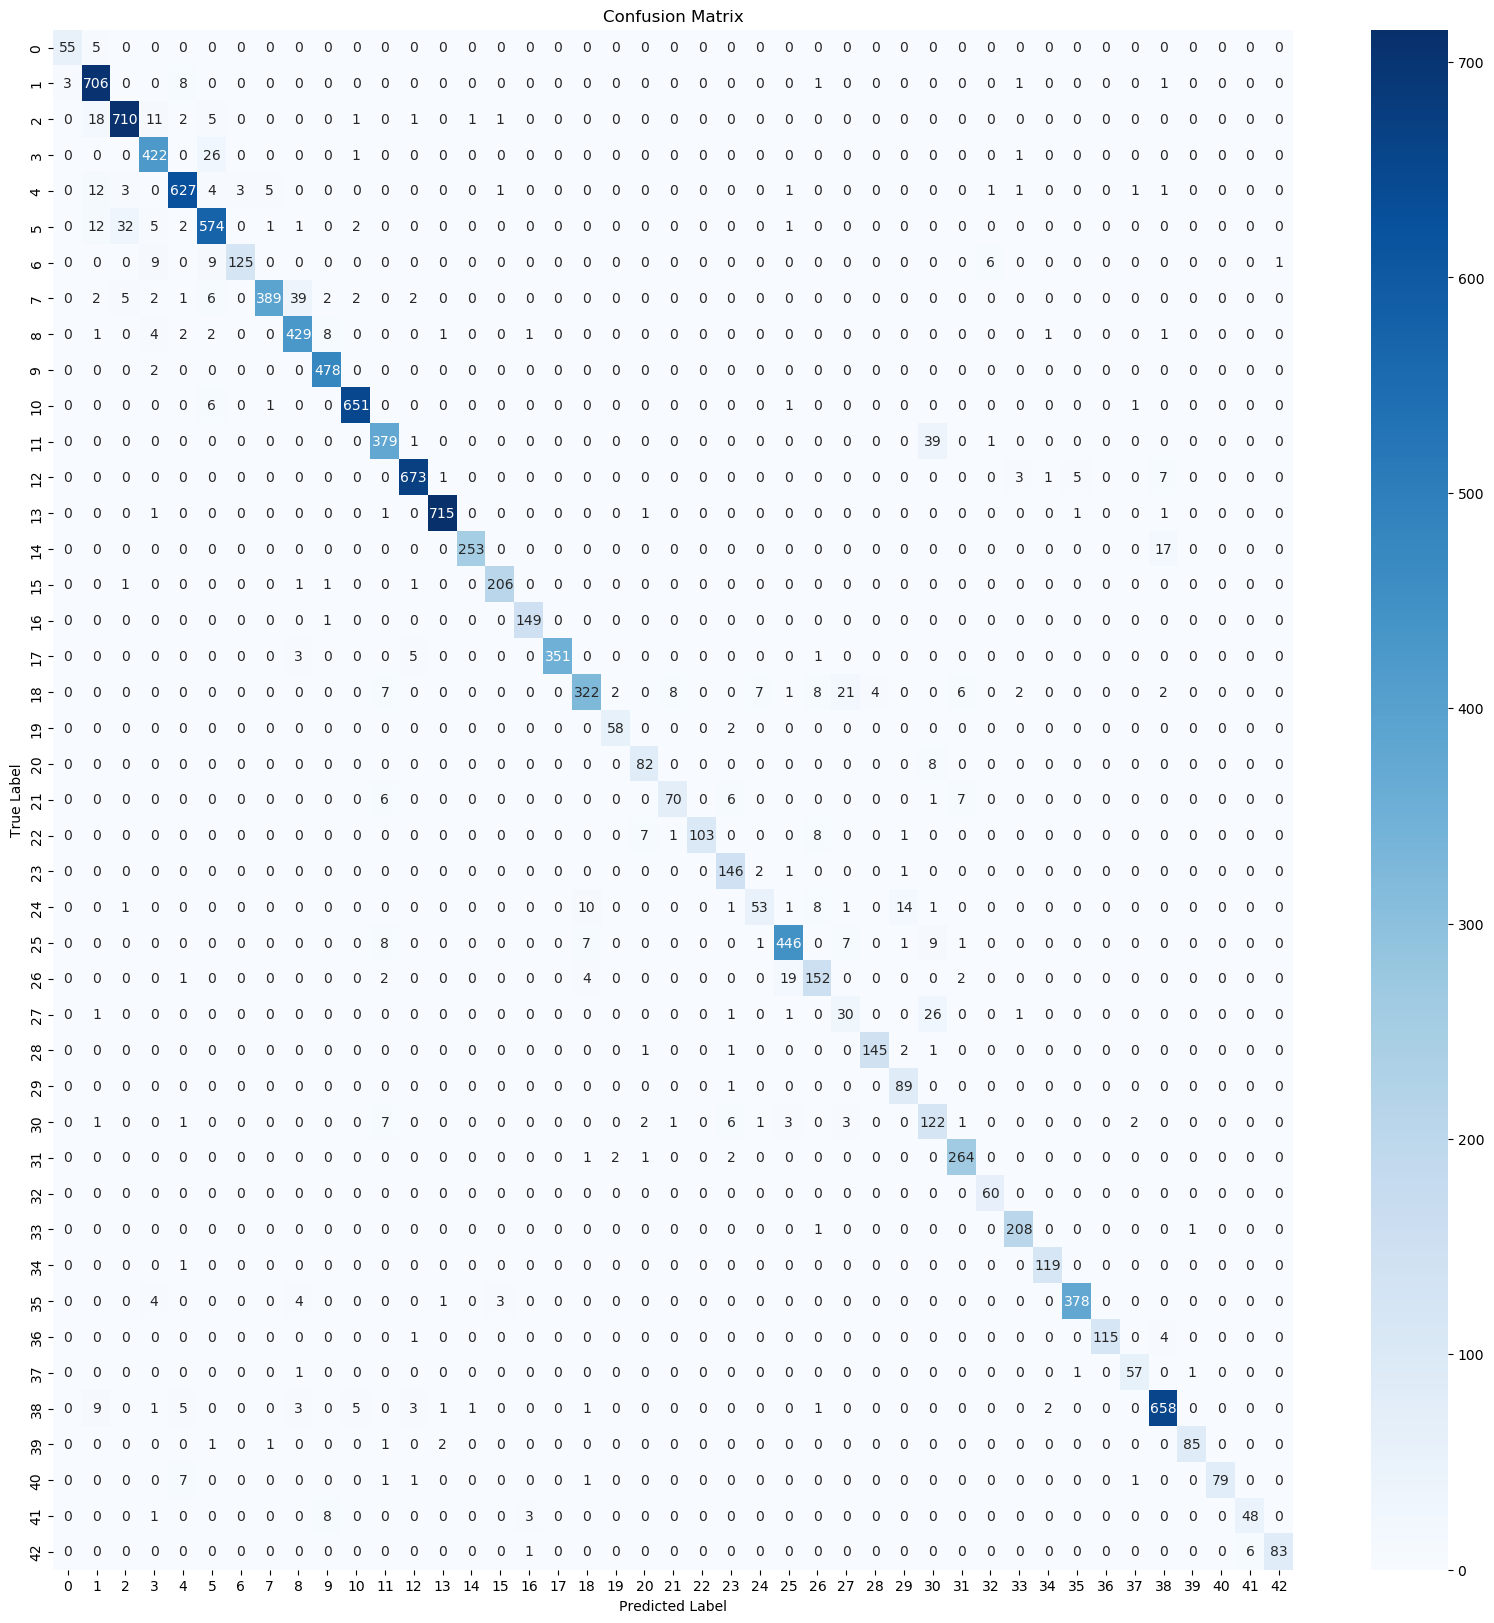

In [57]:
# 可視化混淆矩陣
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()